# Notebook de modélisation

## Mise en place et informations générales

Librairies et paramétrages utilisés au cours du notebook 

In [1]:
import string

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from gower_dist import gower_distance
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import dendrogram, complete

In [2]:
%matplotlib inline
plt.style.use(style='seaborn-white')
mpl.rcParams['figure.dpi'] = 100

Chargeons les données et affichons un aperçu des données nettoyées précédemment

In [3]:
movies = pd.read_csv('data/movies.csv', index_col=[0])
data = pd.read_csv('data/cleaned_data.csv', index_col=[0])

data.head()

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,aspect_ratio,cast_total_facebook_likes,color,director_facebook_likes,...,genre_documentary,genre_western,genre_romance,genre_biography,is_TV,rating_G,rating_PG,rating_PG-13,rating_R,rating_NC-17
id,,,,,,,,,,,,,,,,,,,,,
499549,0.001563,0.081633,0.006832,0.20,0.037174,0.375,0.379747,0.007361,1,0.000000,...,0,0,0,0,0,0,0,1,0,0
449088,0.062500,0.836735,0.036496,0.35,0.043478,0.500,0.740506,0.073622,1,0.024478,...,0,0,0,0,0,0,0,1,0,0
2379713,0.017188,0.102041,0.002869,0.10,0.007000,0.125,0.740506,0.017816,1,0.000000,...,0,0,0,0,0,0,0,1,0,0
1345836,0.042188,0.224490,0.167883,0.25,1.000000,0.250,0.740506,0.162561,1,0.956522,...,0,0,0,0,0,0,0,1,0,0
5289954,0.000205,0.020408,0.000088,0.05,0.016152,0.125,0.572610,0.000218,1,0.005696,...,1,0,0,0,0,0,0,0,1,0


Décrivons brièvement les différentes variables

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4919 entries, 499549 to 378407
Data columns (total 55 columns):
actor_1_facebook_likes       4919 non-null float64
actor_1_name                 4919 non-null float64
actor_2_facebook_likes       4919 non-null float64
actor_2_name                 4919 non-null float64
actor_3_facebook_likes       4919 non-null float64
actor_3_name                 4919 non-null float64
aspect_ratio                 4919 non-null float64
cast_total_facebook_likes    4919 non-null float64
color                        4919 non-null int64
director_facebook_likes      4919 non-null float64
director_name                4919 non-null float64
duration                     4919 non-null float64
gross                        4919 non-null float64
imdb_score                   4919 non-null float64
language                     4919 non-null int64
movie_facebook_likes         4919 non-null float64
num_critic_for_reviews       4919 non-null float64
num_user_for_reviews   

Prompt utilisateur: 
- demande un nom (ou une partie du nom) de film,
- propose une liste d'éléments correspondant à ce qui a été entré 
- effectue choix final, parmi les éléments disponibles
- affiche le lien pour avoir la recommendation

In [5]:
checkpoint = False
while not checkpoint:
    i = input("Veuillez entrer le nom ou une partie du nom valide d'un film: ")
    entry_movie = i.translate(str.maketrans('','',string.punctuation)).lower().strip()
    response = movies['movie_search'].str.contains(entry_movie)
    if response.sum():
        checkpoint = True

print("\n\nVoici les films correspondant aux mots-clés entrés: ")
print(movies.loc[response, 'movie_title'])



Voici les films correspondant aux mots-clés entrés: 
id
417741            Harry Potter and the Half-Blood Prince
373889         Harry Potter and the Order of the Phoenix
330373               Harry Potter and the Goblet of Fire
304141          Harry Potter and the Prisoner of Azkaban
1680310    Harry Potter and the Deathly Hallows: Part II
241527             Harry Potter and the Sorcerer's Stone
1571403     Harry Potter and the Deathly Hallows: Part I
295297           Harry Potter and the Chamber of Secrets
Name: movie_title, dtype: object


In [6]:
entry_id = input("Entrez l'id du film désiré: ")
print("\n\nRendez vous sur https://volet-projet-3.herokuapp.com/recommend/" + entry_id)



Rendez vous sur https://volet-projet-3.herokuapp.com/recommend/304141


## Modèles de distances

Calcul de distances entre chaque couple de film à l'aide de plusieurs métriques connues:
- de Manhattan
- Euclidiennne
- de Correlation
- Coefficient de Gower

Calculons les matrices de distances pour chacune des mesures

In [7]:
metrics = ['cityblock', 'euclidean', 'correlation', 'gower']
distance_matrices = []

for metric in metrics:
    if metric=='gower':
        matrix = gower_distance(data)
    else:
        matrix = squareform(pdist(data.values, metric=metric))
    np.save('distances/'+metric+'_matrix.npy', matrix)
    distance_matrices.append(matrix)

Ou chargeons-les depuis les sauvegardes antécédantes

In [8]:
metrics = ['cityblock', 'euclidean', 'correlation', 'gower']
distance_matrices = []

for metric in metrics:
    matrix = np.load('distances/'+metric+'_matrix.npy')
    distance_matrices.append(matrix)

Chercher les plus proches avec la matrice de distances calculée avec la distance de Gower, selon l'`id` précédemment entré par l'utilisateur 

In [9]:
gower_matrix = distance_matrices[3]

movie_loc = movies.index.get_loc(int(entry_id))
movie_dist = gower_matrix[movie_loc,:]

locs = np.argpartition(movie_dist, 6) # Six premiers films, film entré lui même compris
idx = movies.iloc[locs[:6], :].index.tolist()
idx.remove(int(entry_id)) # retirer le film recherché de la liste retournée

movies.loc[idx, 'movie_title'].to_json()

'{"363771":"The Chronicles of Narnia: The Lion, the Witch and the Wardrobe","417741":"Harry Potter and the Half-Blood Prince","1623205":"Oz the Great and Powerful","241527":"Harry Potter and the Sorcerer\'s Stone","373889":"Harry Potter and the Order of the Phoenix"}'

## Modèles de clustering

### Réduction de dimensions

Afin d'avoir l'hyperespace le plus condensé possible, tout en conservant une grande partie de l'information de l'espace initial, nous appliquons l'algorithme ACP. 

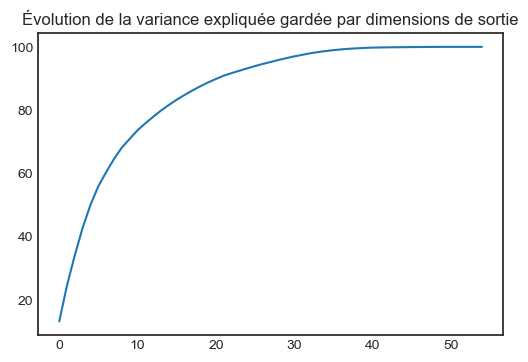

In [10]:
pca = PCA(data.shape[1])
pca.fit(data)
plt.plot(pca.explained_variance_ratio_.cumsum()*100)
plt.title('Évolution de la variance expliquée gardée par dimensions de sortie');

Avec 28 dimensions en sortie, soit une réduction par un 2 deux de l'espace initial, nous conservons 95% de l'information.

In [11]:
pca = PCA(0.95)
transformed_data = pca.fit_transform(data)
transformed_data.shape

(4919, 28)

### K-Means

Premier algorithme de clustering: k-means

In [12]:
distortions = []
silhouettes = []
n = 30


for i in range(2, n+1):
    km = KMeans(n_clusters=i, init='k-means++',
                n_init=20, max_iter=1000, tol=0.0001,
                verbose=0, n_jobs=-1)
    km.fit(transformed_data)
    distortions.append(km.inertia_)

Évolution de la distortion inter-clusters en fonction du nombre `k` choisi.

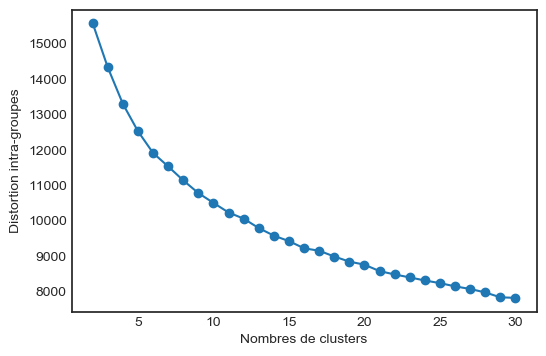

In [13]:
plt.plot(range(2,n+1), distortions, marker='o')
plt.xlabel('Nombres de clusters')
plt.ylabel('Distortion intra-groupes');

Choix: 10 clusters, à partir duquel la distortion ne diminue que de manière marginale à chaque itération

Affichons la répartition du nombre d'instance par cluster

In [14]:
km = KMeans(n_clusters=10, init='k-means++',
            n_init=20, max_iter=1000, tol=0.0001,
            verbose=0, n_jobs=-1)
km.fit(transformed_data)
y_km = km.labels_

unique, counts = np.unique(y_km, return_counts=True)
for label, count in zip(unique, counts):
    print('Cluster {0}: {1}'.format(label, count))

Cluster 0: 471
Cluster 1: 620
Cluster 2: 520
Cluster 3: 389
Cluster 4: 390
Cluster 5: 525
Cluster 6: 509
Cluster 7: 414
Cluster 8: 430
Cluster 9: 651


Évaluation de cette clusterisation: mesure silhouette

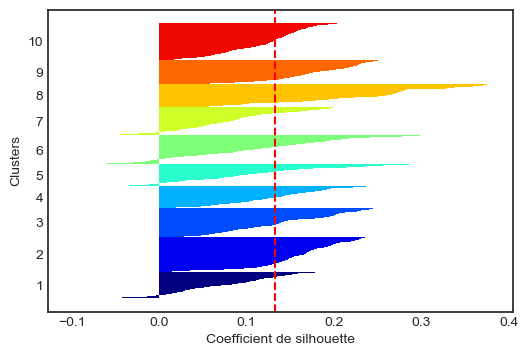

In [15]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(transformed_data, 
                                     y_km,
                                     metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Clusters')
plt.xlabel('Coefficient de silhouette');

Coefficient moyen faible: 0.14. On peut interpréter cela en disan que les instances ne sont pas étroitements liées entre dans un même cluster. On remarque aussi une grosse disparité du score par instance dans un même cluster.

Qui plus est, ce modèle pose plusieurs limitations:
- initialisation aléatoire
- besoin de spécifier nombre de clusters
- forme des clusters supposée convexe
- toutes les directions sont d'importance égale

donc kmeans ne capture que des formes de clusters assez simples

### Clustering hierarchique (agglomératif)

Pour tenter de contourner certaines des limitations de l'algorithme k-means, on utilise le clustering hiérarchique agglomératif:
- pas de contrainte sur la forme de ses clusters
- pas besoin de spécifier le nombre de clusters d'emblée
- visualisation facile pour interpréter les résultats avec un dendogramme

Utilisons la matrice de distances avec la mesure dite de 'Manhattan' sur nos instances, et affichons le dendogramme résultant. La méthode de fusions des clusters retenue est celle dite _complete_: on assemblera itérativement deux clusters en comparant les deux membres les plus éloignés des clusters.

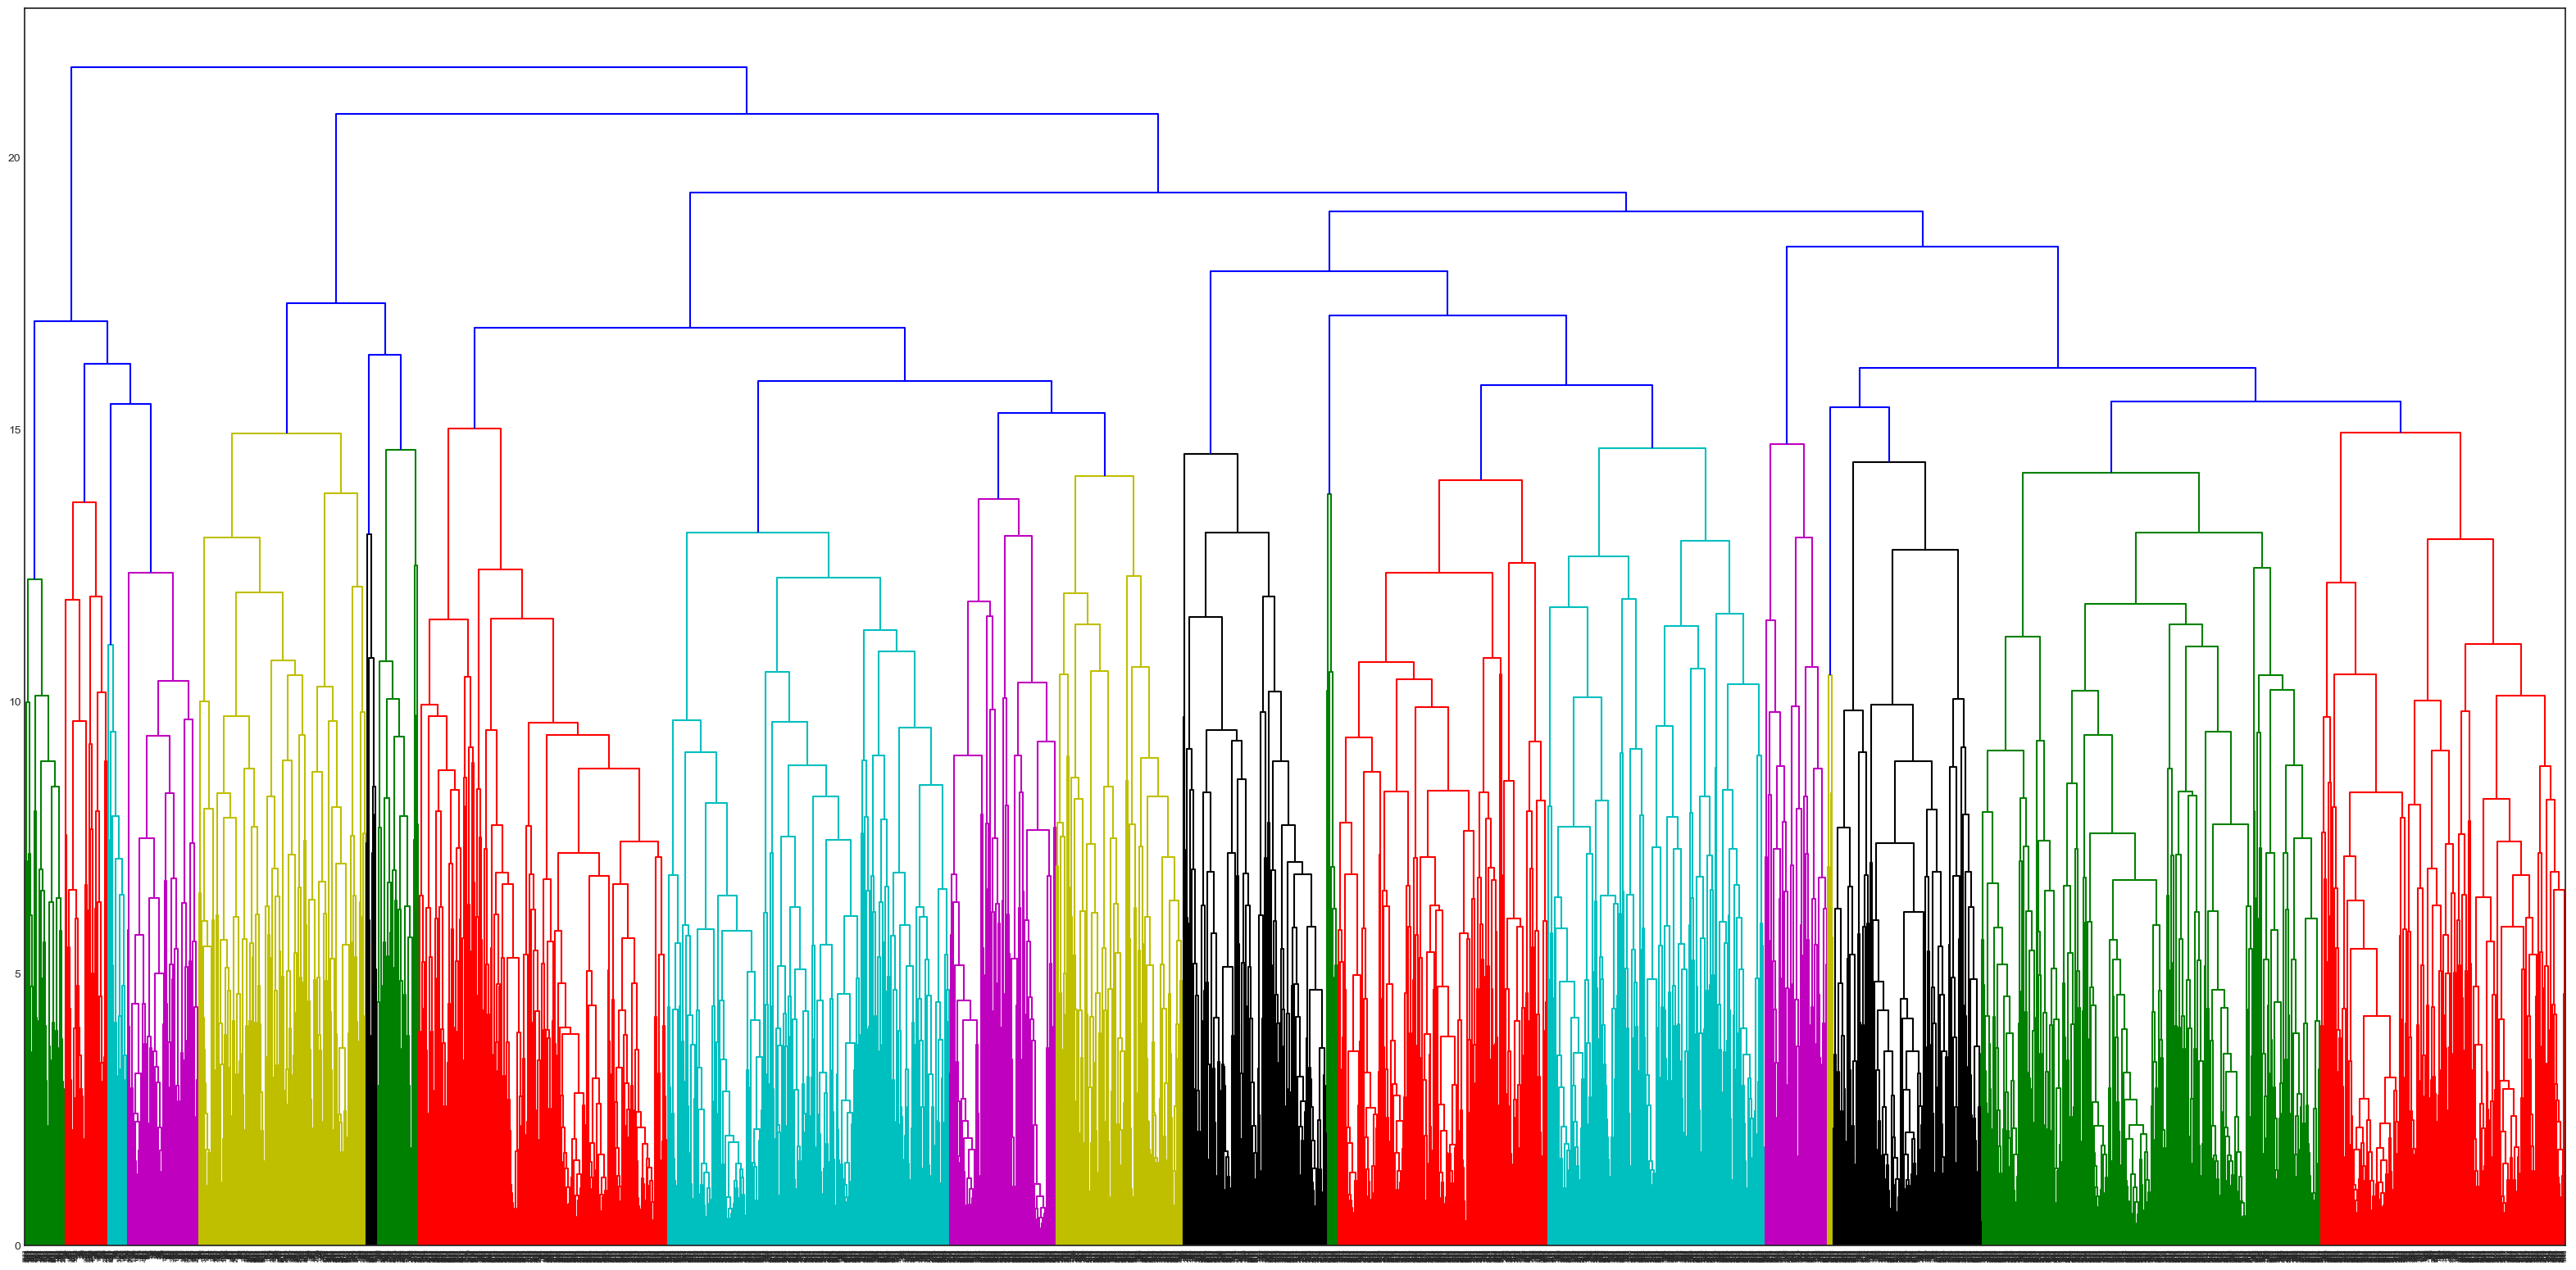

In [16]:
condensed_distance = pdist(data.values, metric='cityblock')
# calcul des distances dans le rassemblement des clusters agglomératif
linkage_array = complete(condensed_distance) 

# Affichage du dendogramme avec les distances entre les clusters
plt.figure(figsize=(40, 20))
R = dendrogram(linkage_array, truncate_mode='level');

Compte tenu du grand nombre d'instances que présente notre jeu de données, ce dendogramme apparait d'emblée comme peu lisible. Il y est aussi plus difficile de choisir une distance seuil à laquelle on sélectionnerait des nœuds, dont les feuilles seraient les groupes de clusters.

Afin de ne pas obtenir des clusters trop petits, et de minimiser le coefficient moyen de silhouette, nous choisissons d'après notre dendogramme de partitionne nos données en 8 clusters.

In [23]:
ch = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='complete')
distance_matrix = squareform(pdist(data.values, metric='cityblock'))
ch.fit(distance_matrix)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=7, pooling_func=<function mean at 0x107ee6598>)

Affichons le nombre d'instances par clusters

In [24]:
unique, counts = np.unique(ch.labels_, return_counts=True)
for label, count in zip(unique, counts):
    print('Cluster {0}: {1}'.format(label, count))

Cluster 0: 425
Cluster 1: 337
Cluster 2: 850
Cluster 3: 1480
Cluster 4: 1429
Cluster 5: 120
Cluster 6: 278


Pour cette partition, calculons le coefficient de silhouette de nos instances

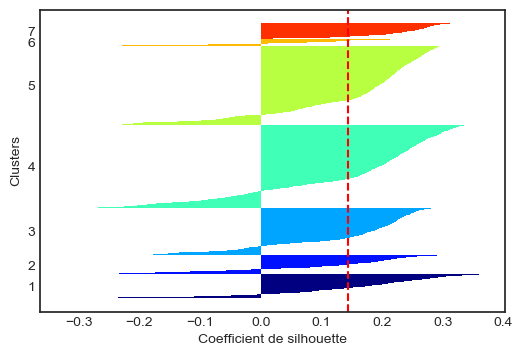

In [25]:
y_ch = ch.labels_
cluster_labels = np.unique(y_ch)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(distance_matrix, 
                                     y_ch,
                                     metric='precomputed')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_ch == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Clusters')
plt.xlabel('Coefficient de silhouette');

In [26]:
silhouette_avg

0.1442503746794028

On se retrouve avec un coefficient de silhouette légèrement plus fort en moyenne cette fois-ci, mais il n'est encore une fois par très fort. Statistiquement, nos clusters ne sont donc pas robuste.

Même si on avait un *clustering* très robuste/compact, traduit par une grande valeur au score de silhouette, celui-ci ne serait pas forcément significatif sémantiquement dans la classification. Les clusters pourraient aussi ne pas refléter une catégorisation des données qui nous intéresse.

La seule manière de savoir si le clustering correspond à quelque chose d'intéressant pour nous est de les analyser les clusters manuellement.